In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from glob import glob

from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import jaccard_score
from pathlib import Path

import sys
sys.path.append('../')
from torchlib.metrics import get_metrics

import staple
#import seaborn as sns;sns.set_theme()

In [2]:
def show(src, titles=[], suptitle="", 
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    plt.figure(figsize=(bwidth * num_cols, bheight))
    plt.suptitle(suptitle)

    for idx in range(num_cols):
        plt.subplot(1, num_cols, idx+1)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        plt.savefig(save_file)
        
def show2(src, titles=[], suptitle="", show_fig=True,
         bwidth=4, bheight=4, save_file=False,
         show_axis=True, show_cbar=False):

    num_cols = len(src)
    
    fig = plt.figure(figsize=(bwidth * num_cols, bheight*2))
    plt.suptitle(suptitle)

    add = 0
    for idx in range(num_cols):
        
        plt.subplot(2, int(np.ceil(num_cols//2)), idx+1+add)
        if not show_axis: plt.axis("off")
        if idx < len(titles): plt.title(titles[idx])
        plt.imshow(src[idx]*1)
        if type(show_cbar) is bool:
            if show_cbar: plt.colorbar()
        elif idx < len(show_cbar) and show_cbar[idx]:
            plt.colorbar()
        
    plt.tight_layout()
    if save_file:
        Path(save_file).parent.mkdir(exist_ok=True, parents=True)
        plt.savefig(save_file)
        
    if not show_fig:
        plt.close(fig)

# Data

In [3]:
def dice_score(gt, seg):
    jac = jaccard_score(gt.ravel(), seg.ravel())
    dice = (2*jac)/ (1+jac)
    return dice

def to3(src):
    shape = src.shape
    return np.stack((np.zeros_like(src), 1-src, src), axis=2)

def get_title(src, gt, prefix="", ret_score=False):
    results, n_cells, preds = get_metrics(to3(gt), to3(src), post_label='map')
    predictionlb, prediction, region, output = preds
    title = f"Np: {results['n_cells']} PQ: {results['pq']:0.2f}"
    if ret_score:
        return prefix + title, results['pq']
    return prefix + title



In [4]:
plt.rcParams.update({'font.size': 20})

def get_nw_simple(segs):
    new_segs = np.array(segs).copy()
    results, n_segs = [], []
    alfa   = 1
    mdices = []
    titles = []

    for epoch in range(4):
        MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
        titles.append(get_title(MV, gt, f"It {epoch} Ni {new_segs.shape[0]} "))
        results.append(MV)
        n_segs.append(len(new_segs))
        seg_score = []
        for seg in new_segs:
            jac = jaccard_score(MV.ravel(), seg.ravel())
            dice = (2*jac)/ (1+jac)
            seg_score.append([dice, seg])


        seg_score  = np.array(seg_score, dtype=object)
        #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
        wdice = seg_score[:, 0].sum()
        mdice = seg_score[:, 0].mean()
        sdice = seg_score[:, 0].std()

        t = mdice - (alfa*sdice)
        new_segs = np.array((list(filter(lambda x: x[0]> t, seg_score))))
        if new_segs.size ==0:break
        new_segs = new_segs[:, 1]
    return MV

def get_simple(segs, alfa=0.2):
    new_segs = np.array(segs).copy()
    results, n_segs = [], []
    
    MV = (new_segs.sum(0)>= new_segs.shape[0]//2)
    new_weights = np.ones(len(new_segs))
    mdices = []
    titles = []


    for epoch in range(6):

        MV = (new_segs.transpose(1,2,0) * new_weights).sum(2) >= (new_weights.sum()/2)
        titles.append(get_title(MV, gt, f"It {epoch} Ni {new_segs.shape[0]} "))
        results.append(MV)
        n_segs.append(len(new_segs))

        dices = []
        for seg in new_segs:
            jac = jaccard_score(MV.ravel(), seg.ravel())
            dice = (2*jac)/ (1+jac)
            dices.append(dice)

        dices  = np.array(dices)
        #sorted_seg = np.array(sorted(seg_score, key=lambda x:x[0], reverse=True))
        wdice = dices.sum()
        mdice = dices.mean()
        sdice = dices.std()
        mdices.append(mdice)

        t = mdice - (alfa * sdice)
        new_segs = new_segs[dices > t]
        if new_segs.size ==0:break
        new_weights = dices[dices > t]
        if len(new_segs)<=1:
            break
        return MV

In [5]:
df = pd.read_csv("../extra/summary.csv")
df = df[df.subset == 'train']
df.head()

,dataset,subset,model,post,WPQ,WSQ,WRQ,PCells,Cells,Images
6,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.628784,0.811265,0.769326,754,760,109
7,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.620728,0.803648,0.764296,699,760,109
8,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,map,0.590737,0.814801,0.720322,871,760,109
15,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.622620,0.808980,0.764163,785,760,109
16,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.602604,0.797901,0.746192,719,760,109


In [6]:
target = 760

N = 1.5
max_target = int(target*N)
min_target = int(target/N)
max_target, min_target

inrange = (max_target > df.PCells) & (df.PCells > min_target)
df1 = df[inrange]
df.shape, df[inrange].shape

((402, 10), (322, 10))

<AxesSubplot:title={'center':'Number of cells predicted (correct 760)'}>

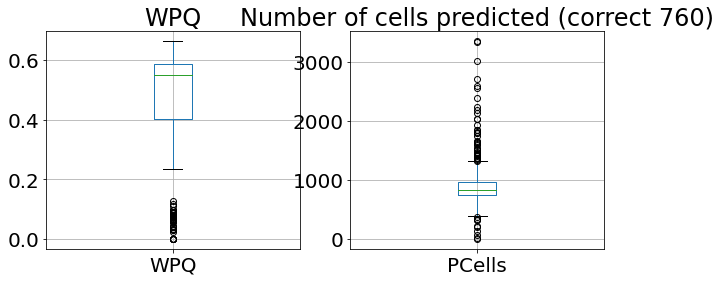

In [7]:
dfcells =  df[df.PCells < 4000]

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("WPQ")
df.boxplot(column=["WPQ"])
plt.subplot(122)
plt.title("Number of cells predicted (correct 760)")
dfcells.boxplot(column=["PCells"])

<AxesSubplot:title={'center':'Number of cells predicted (correct 760)'}>

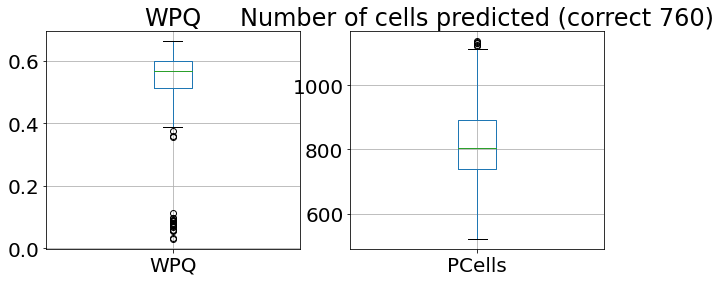

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("WPQ")
df1.boxplot(column=["WPQ"])
plt.subplot(122)
plt.title("Number of cells predicted (correct 760)")
df1.boxplot(column=["PCells"])

In [9]:
df[inrange].WPQ.describe()

count    322.000000
mean       0.526694
std        0.135512
min        0.029613
25%        0.513754
50%        0.568421
75%        0.599995
max        0.662747
Name: WPQ, dtype: float64

In [10]:
df[inrange].PCells.describe()

count     322.000000
mean      821.990683
std       122.042827
min       521.000000
25%       739.000000
50%       804.500000
75%       891.750000
max      1137.000000
Name: PCells, dtype: float64

# Filter 2 - PQ

In [11]:
th_pq = df1.WPQ.mean() - (df1.WPQ.std())

df2 = df1[df1.WPQ > th_pq]
df2

,dataset,subset,model,post,WPQ,WSQ,WRQ,PCells,Cells,Images
6,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.628784,0.811265,0.769326,754,760,109
7,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.620728,0.803648,0.764296,699,760,109
8,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,map,0.590737,0.814801,0.720322,871,760,109
15,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.622620,0.808980,0.764163,785,760,109
16,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.602604,0.797901,0.746192,719,760,109
...,...,...,...,...,...,...,...,...,...,...
1185,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.482394,0.770774,0.614363,1021,760,109
1186,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.496957,0.772974,0.632997,867,760,109
1194,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,th,0.637434,0.816825,0.763498,747,760,109
1195,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,wts,0.636136,0.815240,0.762883,709,760,109


<AxesSubplot:title={'center':'Number of cells predicted (correct 760)'}>

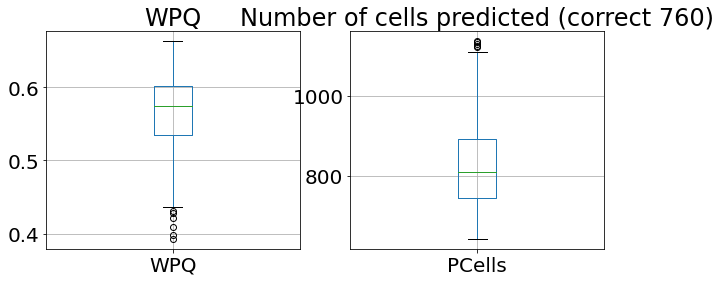

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("WPQ")
df2.boxplot(column=["WPQ"])
plt.subplot(122)
plt.title("Number of cells predicted (correct 760)")
df2.boxplot(column=["PCells"])

# Sample - Top

In [13]:
df2[['model_sup', 'ckpt']] = df2.model.str.split("/", expand=True)[[10, 12]]
df2 = df2.sort_values("WPQ", ascending=False, ignore_index=True)#.iloc[::10]

In [14]:
sample = df2.groupby(["model_sup", "post"], as_index=False).first()
sample

,model_sup,post,dataset,subset,model,WPQ,WSQ,WRQ,PCells,Cells,Images,ckpt
0,baseline_unetpad_mce__adam_FluoC2DLMSC_0.1.1-1...,map,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.644967,0.818816,0.772425,769,760,109,chk000320.pth.tar
1,baseline_unetpad_mce__adam_FluoC2DLMSC_0.1.1-1...,th,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.662747,0.816719,0.794209,681,760,109,chk000320.pth.tar
2,baseline_unetpad_mce__adam_FluoC2DLMSC_0.1.1-1...,wts,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.657296,0.816304,0.789578,662,760,109,chk000320.pth.tar
3,baseline_unetpad_mce_step__adam_FluoC2DLMSC_0....,map,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.594653,0.812753,0.727061,844,760,109,chk000195.pth.tar
4,baseline_unetpad_mce_step__adam_FluoC2DLMSC_0....,th,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.630520,0.806346,0.775364,742,760,109,chk000120.pth.tar
5,baseline_unetpad_mce_step__adam_FluoC2DLMSC_0....,wts,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.620728,0.803648,0.764296,699,760,109,chk000193.pth.tar
6,baseline_unetpad_wce_step_SAW_adam_FluoC2DLMSC...,map,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.571542,0.782993,0.708526,829,760,109,chk000260.pth.tar
7,baseline_unetpad_wce_step_SAW_adam_FluoC2DLMSC...,th,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.586504,0.780317,0.729211,754,760,109,chk000200.pth.tar
8,baseline_unetpad_wce_step_SAW_adam_FluoC2DLMSC...,wts,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.586706,0.771045,0.735591,698,760,109,chk000220.pth.tar
9,baseline_unetpad_wce_step_SAW_adam_FluoC2DLMSC...,map,FluoC2DLMSC_0.1.1,train,/home/chcp/Documents/Mestrado/MedicalImageSegm...,0.561151,0.817522,0.679462,964,760,109,chk000299.pth.tar


In [15]:
url_path = sample['model'].values
post_name = sample['post'].values

In [16]:
from torchlib.metrics import PQ
pq_score = PQ()

In [17]:
subset = 'val'
data_len = 14
pq_matrix = np.zeros((data_len, len(url_path), len(url_path)))
for idx in range(data_len):
    np.fill_diagonal(pq_matrix[idx], 1)

for model_idx in range(len(url_path)):
    ppname = Path(url_path[model_idx]).parent.parent.name
    ckptname = Path(url_path[model_idx]).name
    post = post_name[model_idx]

    for model_idy in range(model_idx+1,len(url_path)):
        ppnamey = Path(url_path[model_idy]).parent.parent.name
        ckptnamey = Path(url_path[model_idy]).name
        posty = post_name[model_idy]

        for img_idx in range(data_len):
            img_idx_n = f"{img_idx:03d}"

            urlx  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppname}*{ckptname}*/*{subset}*{post}_{img_idx_n}_post.*")[0]
            urly  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppnamey}*{ckptnamey}*/*{subset}*{posty}_{img_idx_n}_post.*")[0]
            srcx  = cv2.imread(urlx, -1)
            srcy  = cv2.imread(urly, -1)
            
            pq_xy = pq_score(srcx, srcy)['pq']
            pq_matrix[img_idx, model_idx, model_idy] = pq_xy
            pq_matrix[img_idx, model_idy, model_idx] = pq_xy

In [19]:
def show_num(puzzle, label='', force_zeros=False):
    plt.imshow(puzzle)
    plt.axis('off')
    for (j,i),label in np.ndenumerate(puzzle):
        plt.text(i,j,f"{label:0.2f}",ha='center',va='center', fontsize=20)

Text(0.5, 1.0, 'STD Matrix: PQ vs PQ')

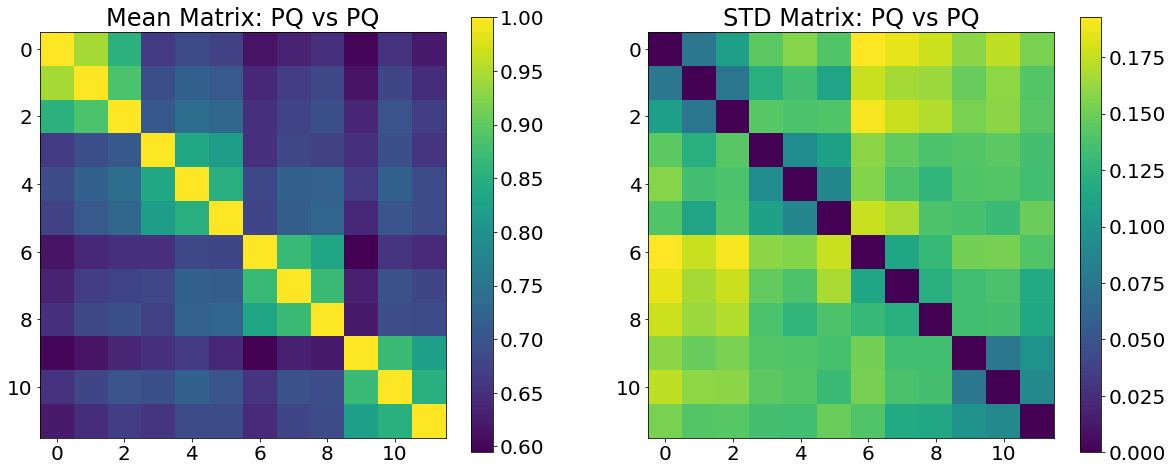

In [20]:
plt.figure(figsize=(20, 8))
plt.subplot(121)
plt.imshow(pq_matrix.mean(0))
#show_num(pq_matrix.mean(0))
plt.colorbar()
plt.title("Mean Matrix: PQ vs PQ")

plt.subplot(122)
#plt.figure(figsize=(20, 20))
plt.imshow(pq_matrix.std(0))
#show_num(pq_matrix.std(0))
plt.colorbar()
plt.title("STD Matrix: PQ vs PQ")

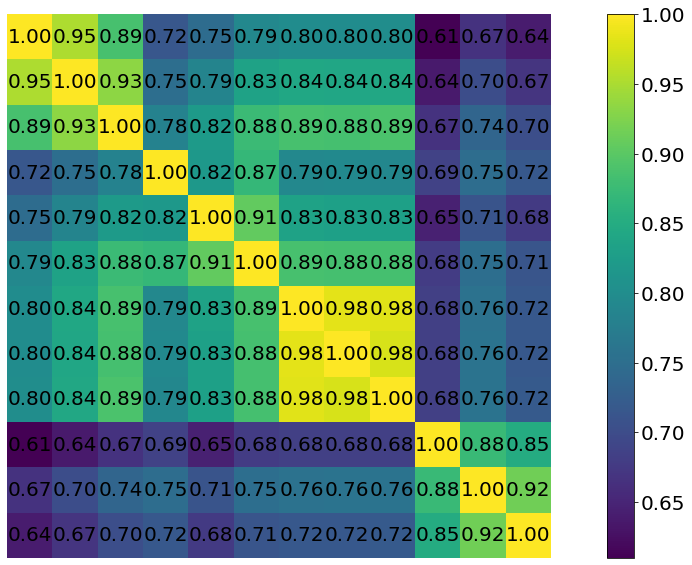

In [21]:
plt.figure(figsize=(20, 10))
show_num(pq_matrix[0])
plt.colorbar()

In [91]:
img_idx = 0
img_idx_n = f"{img_idx:03d}"

gt = cv2.imread(f"../extra/datasetsi/FluoC2DLMSC_0.1.1/{subset}_{img_idx_n}.png", -1)
view = cv2.imread(f"../extra/datasetsv/FluoC2DLMSC_0.1.1/view_{subset}_{img_idx_n}.png")

model_idx = 0
ppname = Path(url_path[model_idx]).parent.parent.name
ckptname = Path(url_path[model_idx]).name
post = post_name[model_idx]

urlx  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppname}*{ckptname}*/*{subset}*{post}_{img_idx_n}_post.*")[0]
srcx  = cv2.imread(urlx, -1)

model_idy0 = 1
ppnamey0 = Path(url_path[model_idy0]).parent.parent.name
ckptnamey0 = Path(url_path[model_idy0]).name
posty0 = post_name[model_idy0]

urly0  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppnamey0}*{ckptnamey0}*/*{subset}*{posty0}_{img_idx_n}_post.*")[0]
srcy0  = cv2.imread(urly0, -1)

model_idy1 = 8
ppnamey1 = Path(url_path[model_idy1]).parent.parent.name
ckptnamey1 = Path(url_path[model_idy1]).name
posty1 = post_name[model_idy1]

urly1  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppnamey1}*{ckptnamey1}*/*{subset}*{posty1}_{img_idx_n}_post.*")[0]
srcy1  = cv2.imread(urly1, -1)

model_idy2 = 9
ppnamey2 = Path(url_path[model_idy2]).parent.parent.name
ckptnamey2 = Path(url_path[model_idy2]).name
posty2 = post_name[model_idy2]

urly2  = glob(f"../extra/outputs/FluoC2DLMSC_0.1.1/{ppnamey2}*{ckptnamey2}*/*{subset}*{posty2}_{img_idx_n}_post.*")[0]
srcy2  = cv2.imread(urly2, -1)



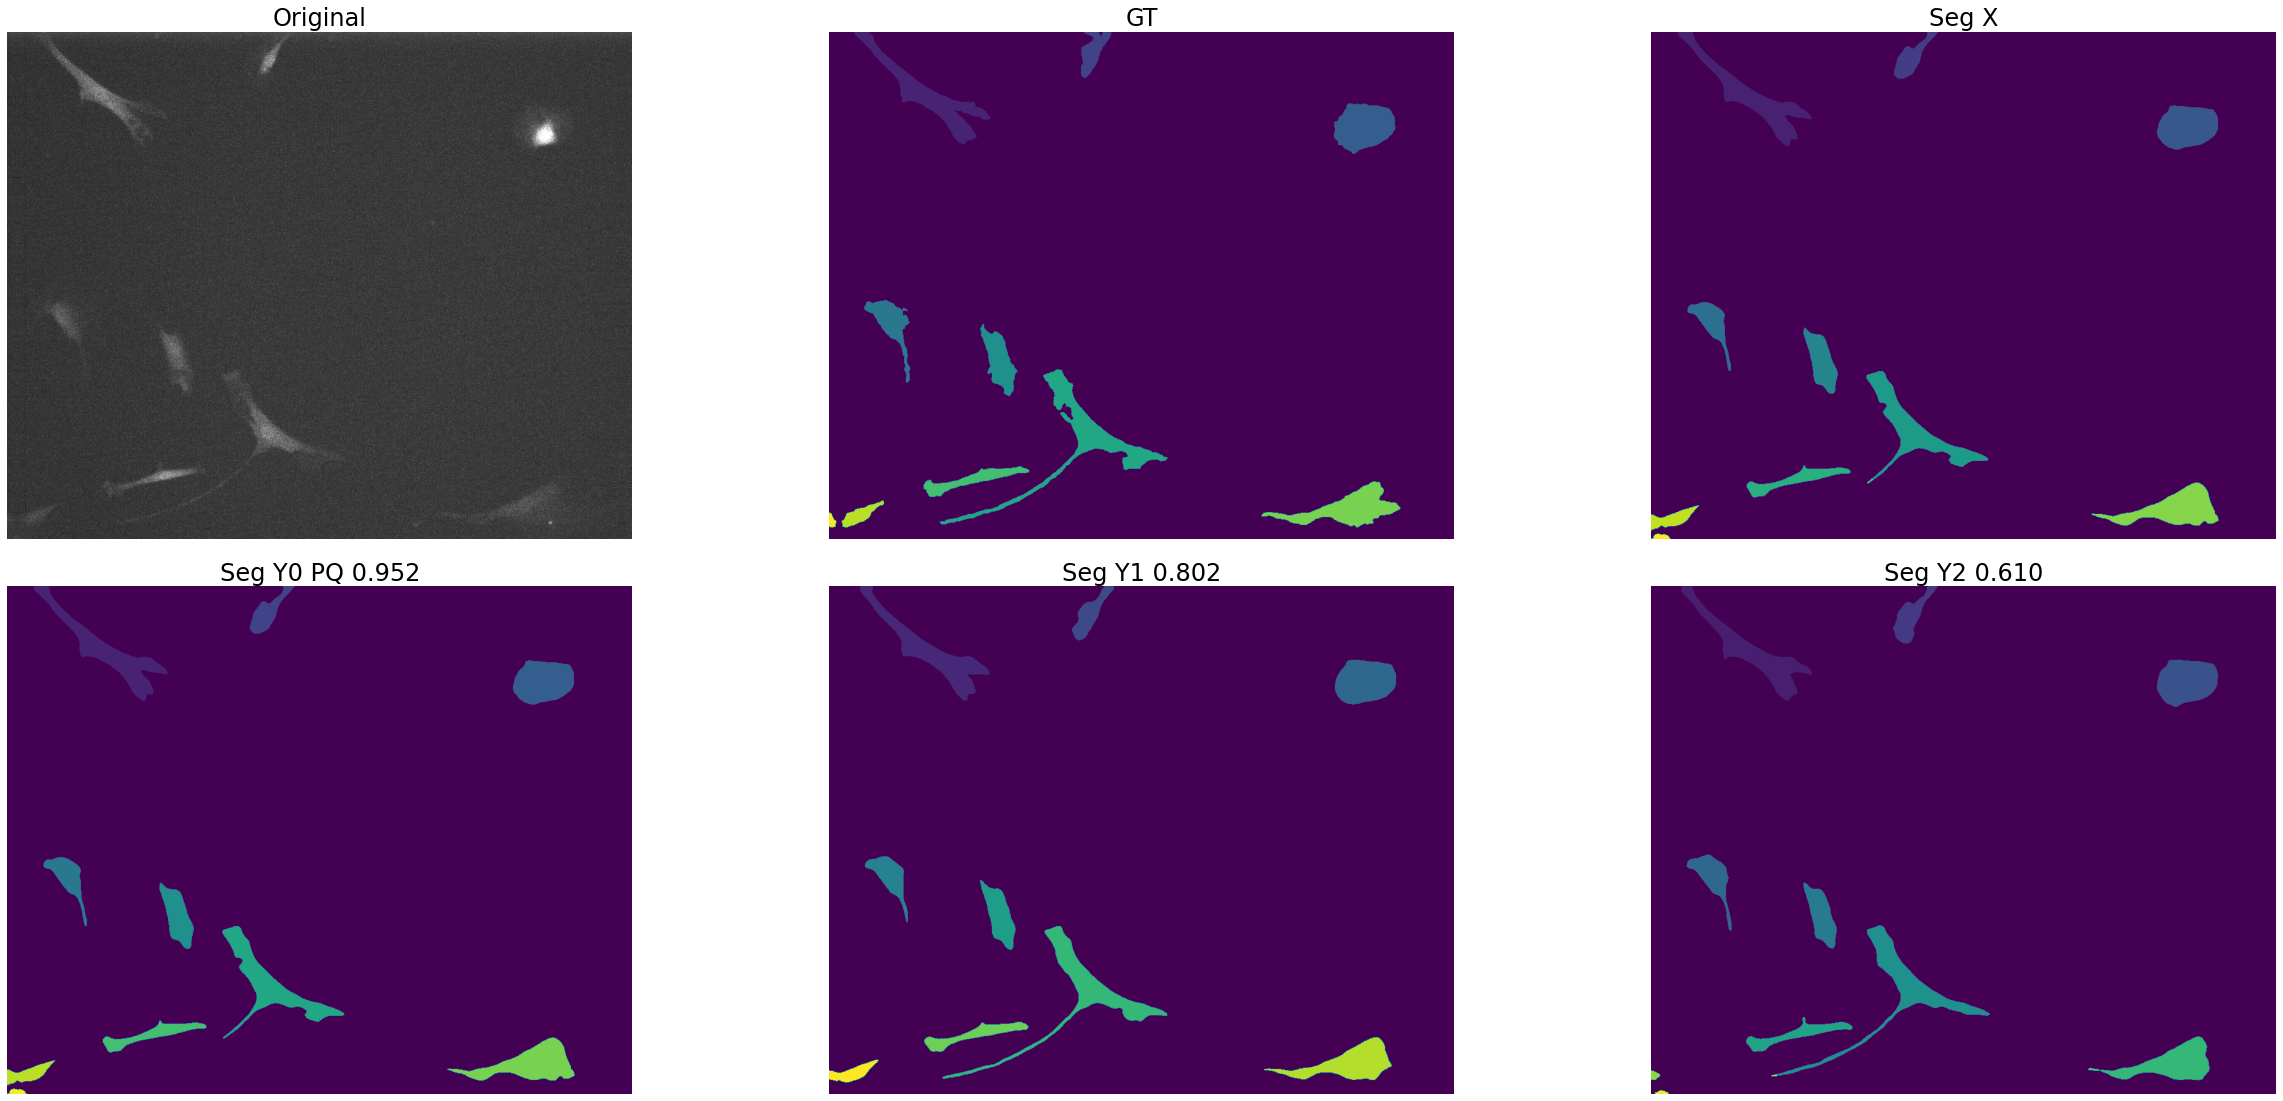

In [95]:
show2([view, gt, srcx, srcy0, srcy1, srcy2], show_axis=False,bwidth=6, bheight=8,
    #save_file="pq_img0_inter.jpg",
    titles=['Original', 'GT', 'Seg X', f'Seg Y0 PQ {pq_matrix[img_idx, model_idx, model_idy0]:0.3f}', f'Seg Y1 {pq_matrix[img_idx, model_idx, model_idy1]:0.3f}', f'Seg Y2 {pq_matrix[img_idx, model_idx, model_idy2]:0.3f}'])